In [6]:
CocoGenerator.preprocess_image??

In [6]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


import keras
import keras.preprocessing.image
# from keras_retinanet.preprocessing.coco import CocoGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf


from PIL import Image
from keras_retinanet.utils.image import preprocess_image # <-- this is the CocoGenerator.preprocess_image() method
from keras_retinanet.utils.image import resize_image # <-- this is CocoGenerator.resize_image()

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)


# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())


from keras_retinanet.models.resnet import custom_objects


model = keras.models.load_model('data/retinanet-model/resnet50_coco_best_v1.2.2.h5', custom_objects=custom_objects)
# print(model.summary())

/home/wnixalo/miniconda3/envs/tfkeras/lib/python3.6/site-packages/keras/models.py:271: UserWarning: Output "non_maximum_suppression_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_2" during training.
  sample_weight_mode=sample_weight_mode)


In [35]:
# create image data generator object
# val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# createa a generator for testing data
# val_generator = CocoGenerator('data/COCO', 'val2017', val_image_data_generator, batch_size=1,)
# index = 0

# image_generator = keras.preprocessing.image.ImageDataGenerator()

def detect_one(image=None, index=0, threshold=0.5, mode = 1):
    # load image if none given:
#     if type(image) == type(None):
#         image = val_generator.load_image(index)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
#     image = val_generator.preprocess_image(image)
#     image, scale = val_generator.resize_image(image)
    
#     annotations = val_generator.load_annotations(index)
#     index += 1

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale

    # visualize detections
    count = 0
    max_score = -1

#     from collections import OrderedDict

#     dets = []

#     max_score2 = -1

    caption = ""
    
#     print(scores)

    # so all this loop does is draw if the max score is above the threshold...
    # why loop if the labels & scores are already sorted?
    if mode == 1:
        for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
            max_score = max(max_score, score)
            if score < threshold:
                continue
            b = detections[0, idx, :4].astype(int)

            assert len(b) == 4

            cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0,0,255), 3)
    #         caption = f'{val_generator.label_to_name(label)} {score:.3f}'
            caption = f'Pilot {score:.3f}'
            cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1., (0,0,0), 4, cv2.LINE_AA)
            cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1., (255,255,255), 2, cv2.LINE_AA)

    else:
        # pull out the most confident predicted label
        b = detections[0, np.argmax(scores), :4].astype(int)

        # draw the bounding box & label+score on the image
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0,0,255), 3)
        caption = f'Pilot {scores[np.argmax(scores)]:.3f}'
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1., (0,0,0), 4, cv2.LINE_AA)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1., (255,255,255), 2, cv2.LINE_AA)

    # print next 4 top labels
    for idx, (label, score) in enumerate(zip(predicted_labels[1:5], scores[1:5])):
        # get bonding box
        b = detections[0, idx, :4].astype(int)
        # draw the bounding box & label+score on the image
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0,255,0), 2)
        caption = f'`{label}` {scores[np.argmax(scores)]:.3f}'
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 3, cv2.LINE_4)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 1, cv2.LINE_4)
        
        
        
    print(caption)
    print(f'Bounding Box: {b}')

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()


def detect_pilot(trainpath = 'data/train/', folder="", threshold=0.5):
    if folder == "":
        print("No folder specified")
        return

    fpaths = [trainpath + folder + '/' + fname for fname in os.listdir(trainpath + folder)]

    idx = np.random.choice(np.arange(len(fpaths)))
    print(f'Image path: {fpaths[idx]}')

    image = fpaths[idx]

    image = Image.open(image)
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    detect_one(image, threshold=threshold)

In [8]:
trainpath = 'data/train/'
folders = os.listdir(trainpath)

Image path: data/train/005452-005591/005568.jpg
processing time:  0.32891082763671875
[ 0.32417992  0.2481634   0.21226983  0.1990795   0.11934936  0.07244693
  0.06385452  0.05422182  0.05227401  0.0495601   0.04843441  0.04810702
  0.04776692  0.04607947  0.04551986  0.04239117  0.04216177  0.04164908
  0.04106549  0.03786197  0.03730761  0.03576935  0.03416885  0.03340375
  0.03297059  0.03269887  0.03247236  0.03246205  0.02943987  0.02857857
  0.02843043  0.02750821  0.02730164  0.02653962  0.02649597  0.02636393
  0.02618311  0.02418825  0.02345519  0.02224412  0.02207406  0.0220546
  0.02191417  0.0213232   0.0203326   0.02002783  0.01921716  0.01887434
  0.01880788  0.01861689  0.01847687  0.01838699  0.01836868  0.0181511
  0.01814735  0.01784575  0.01779697  0.01754129  0.01692866  0.016469
  0.01644791  0.01634585  0.01559621  0.0154995   0.01538277  0.01528511
  0.01512633  0.01472979  0.01471486  0.01459667  0.01448534  0.01445742
  0.0140255   0.01396501  0.01379177  0.01

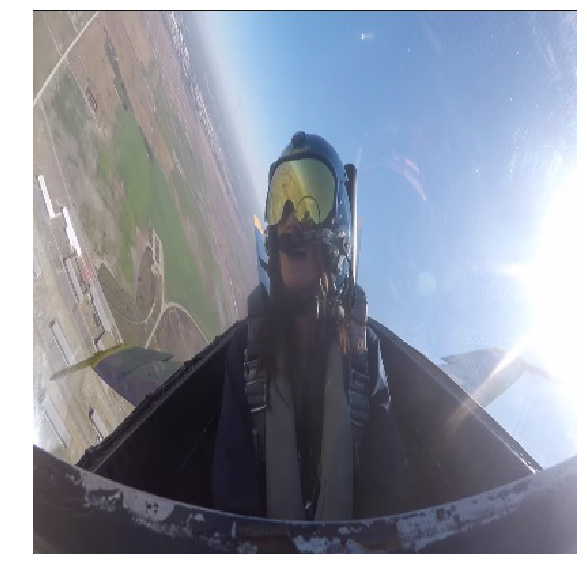

In [12]:
detect_pilot(folder = np.random.choice(folders))

Image path: data/train/004152-004401/004219.jpg
processing time:  0.3296468257904053
[ 0.98097736  0.36776519  0.20009877  0.15813728  0.11980063  0.05528282
  0.05515941  0.05271295  0.04703704  0.04662167  0.03768453  0.03733008
  0.03175164  0.02876113  0.02874993  0.0270119   0.02633474  0.02340586
  0.02336581  0.02290748  0.02192991  0.02188847  0.0217467   0.01992693
  0.01960712  0.01910559  0.01835806  0.01788839  0.01701964  0.01675775
  0.01649043  0.01615028  0.01581278  0.01578158  0.01549809  0.01521159
  0.01519607  0.01500537  0.0149554   0.01483355  0.01447849  0.01438897
  0.0141563   0.01302426  0.01295497  0.01273157  0.01260337  0.01259686
  0.01206274  0.01192933  0.01178838  0.01171817  0.01156303  0.01141839
  0.01132404  0.01125131  0.01109809  0.01090946  0.01080633  0.01047332
  0.01035949  0.01027519  0.01026616  0.0101992   0.01012995  0.01010707
  0.00999509  0.00997026  0.00996144  0.00990104  0.00983274  0.00977527
  0.00971478  0.00956842  0.00955213  0

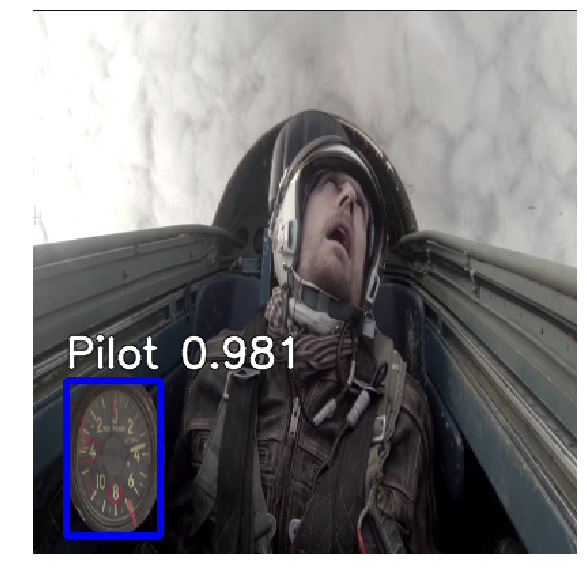

In [14]:
detect_pilot(folder = np.random.choice(folders))

processing time:  0.3278617858886719
Pilot 0.981
Bounding Box: [ 24 272  93 386]


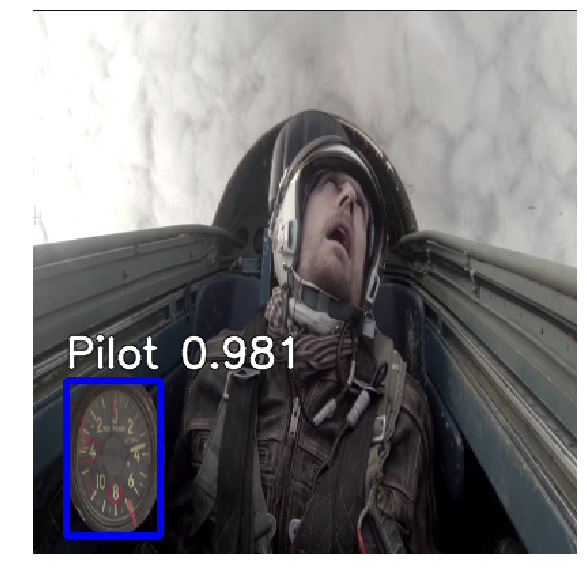

In [25]:
# cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
detect_one(image = cv2.cvtColor(np.asarray(
                                    Image.open("data/train/004152-004401/004219.jpg")), 
                                cv2.COLOR_RGB2BGR),
            mode = 0 )

Image path: data/train/007365-007636/007417.jpg
processing time:  0.32559895515441895
Pilot 0.521
Bounding Box: [ 54  53 258 394]


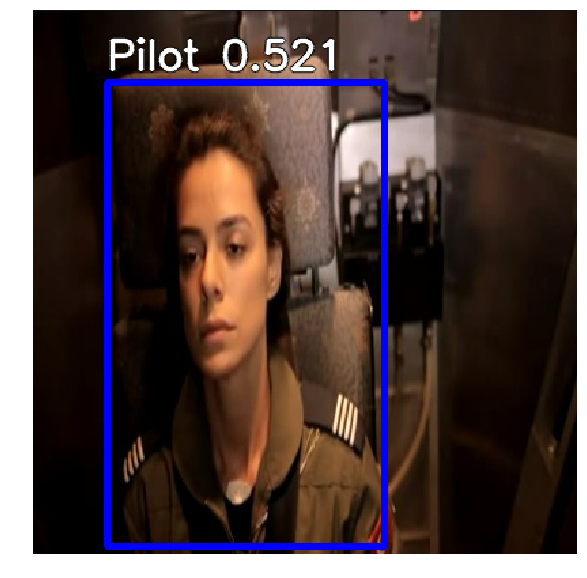

In [26]:
detect_pilot(folder = np.random.choice(folders))

processing time:  0.32092714309692383
Pilot 0.521
Bounding Box: [ 54  53 258 394]


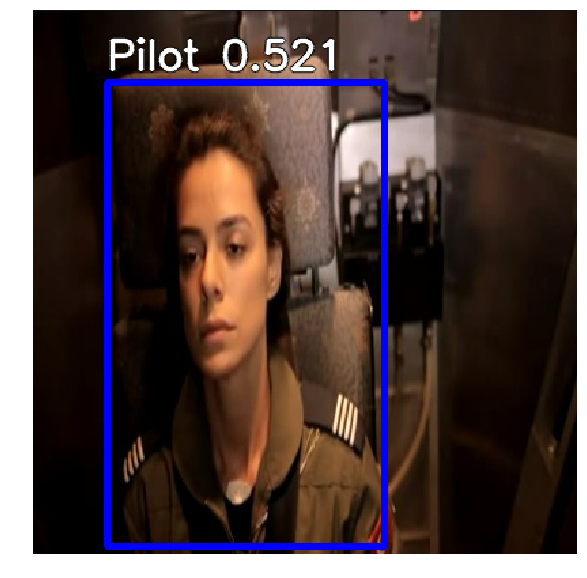

In [29]:
detect_one(image = cv2.cvtColor(np.asarray(
                                    Image.open("data/train/007365-007636/007417.jpg")), 
                                cv2.COLOR_RGB2BGR),
            mode = 2 )

processing time:  0.3256359100341797
`26` 0.521
Bounding Box: [154  12 355 393]


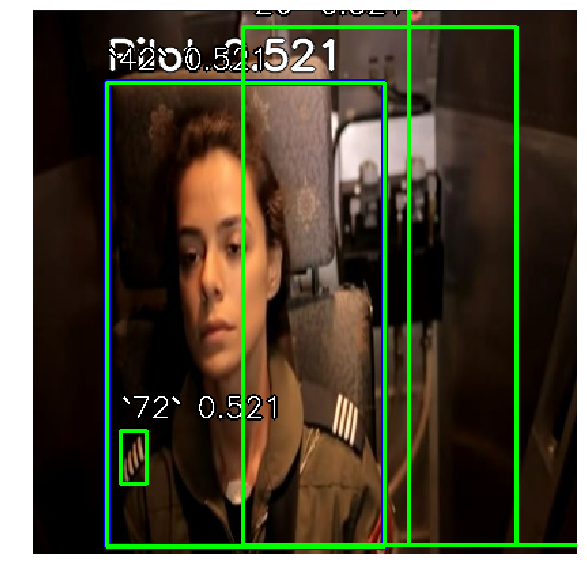

In [36]:
detect_one(image = cv2.cvtColor(np.asarray(
                                    Image.open("data/train/007365-007636/007417.jpg")), 
                                cv2.COLOR_RGB2BGR),
            mode = 2 )

Alright, so my two modes actually do the same thing, which is good.

Image path: data/train/004152-004401/004310.jpg
processing time:  9.52820611000061
Pilot 0.672


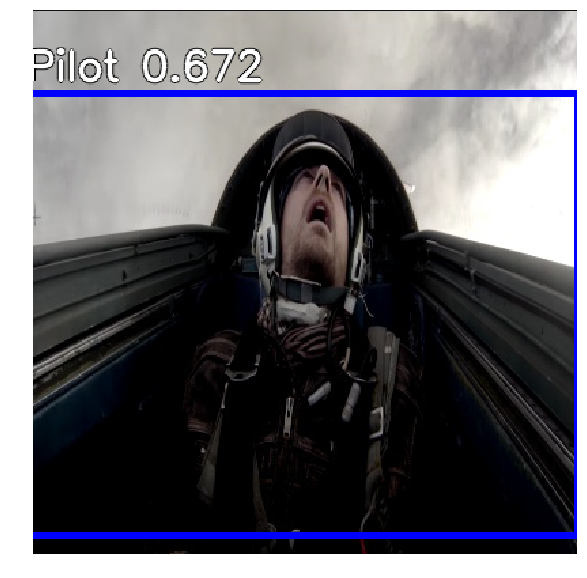

In [17]:
detect_pilot(folder = np.random.choice(folders))

Image path: data/train/001190-001434/001353.jpg
processing time:  0.3241877555847168
`77` 0.337
Bounding Box: [ 33  55 133 280]


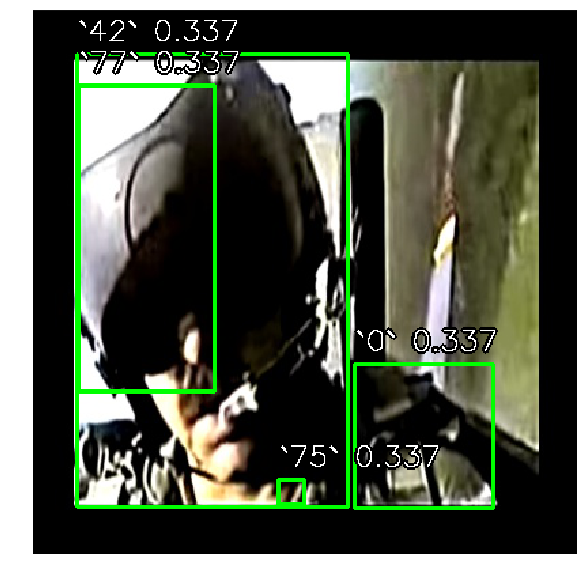

In [39]:
detect_pilot(folder = np.random.choice(folders))

Image path: data/train/005106-005451/005242.jpg
processing time:  0.32173967361450195
`26` 0.959
Bounding Box: [211 317 239 341]


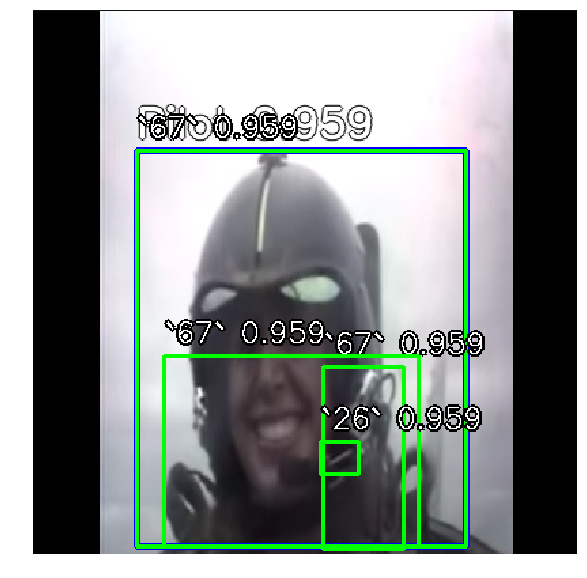

In [40]:
detect_pilot(folder = np.random.choice(folders))

Image path: data/train/006242-006439/006302.jpg
processing time:  0.3207554817199707
`7` 0.525
Bounding Box: [  0 246  41 379]


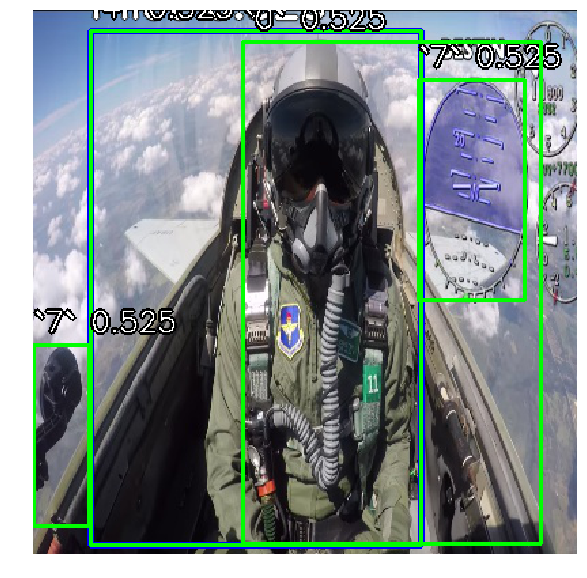

In [41]:
detect_pilot(folder = np.random.choice(folders))

It'd be nice to see what these labels correspond to, although it doesn't actually matter.


OKAY. Here's my idea. Pilot detection is not perfect with off the shelf RetinaNet, but I really *really* **really** ***really*** don't want to write down bounding box coordinates for 7,600 images. I'm not going to do this 'fully-supervised' and the model isn't good enough to be completely unsupervised, so I'm going to try an Online-SemiSupervised approach. *What do I mean?:*

An **Offline Semi-Supervised Approach** would entail the model generating BB coordinates for it's top score above some threshold, and log the filenames of any images it couldn't generate a BB for. Then I go and manually enter coordinates for those images.

The **Online Semi-Supervised Approach** will have me working hand in hand with the 'AI'. Instead of waiting for it to finish working, then beginning my part of the process, the algorithm will present me with each image after it's finished creating BBs. It'll draw it's top-5 predictions, and wait for me to enter the number of the 'most correct' one if such exists. If it couldn't find any it'll automatically log the filename without bothering me.

The Online approach also solves an Offline flaw, that the top-scoring prediction isn't always the pilot. In one example above, the model was very certain of finding a guage and gave that as it's top prediction, ignoring the pilot.

---

This sounds good to me. **So then, tomorrow** I'll:

1. Re-implement this notebook having loaded the COCO-generator just to see the actual labels
2. Write a program to go through and display each image in the dataset with bounding-boxes and record my input
3. Get to work with the 'AI' and create bounding box coordinates for the entire dataset; and handle the negatives manually.

**That's for the 29th.**

**On the 30th** I'll write my own Keras-based RetinaNet training script (and utilities file to handle things like image preprocessing, resizing, and label names -- thankfully the guys at Delft Robotics who wrote this version of RetinaNet already handled the mathematics and (most importantly) the specific dimensional transforms -- *since I don't understand NumPy vector-indexing just yet..*).

After that, with the new BB dataset, I'll finetune RetinaNet on it, and see how it does.

On **New Year's Eve** I aim to write the interstage-image-processing function (ie: when I get my cropped images.. do I send them as they are into the Fully-Conv Networks? Do I scale them and past them into the center of a black 400x400 (224x224 for VGG16) square? Do I just resize them to 400x400 instead? Etc.

Then I test out my 12-Model FastAI/PyTorch Ensemble on the processed cropped images, and probably post some results to twitter, and maybe medium.

**New Year's Day** I hope to begin bringing it all together. My objective is to connect the two stages of this GLOC-supermodel. First part of that is to integrate the image-processing step into the GLOC-RetinaNet program. Secondly is to automate & integrate the image-cropping stage. I want the supermodel's first stage to create a `tmp/` folder of cropped images and corresponding labels, which the FastAI/PyTorch Ensemble will then use as if it were a standard dataset.

*What about Online-SemiSupervision?* **Feature-Creep-WARNING**: I can just set two modes: `US`: UnSupervised, and `SS`: SemiSupervised. That way a user/operator can decide before training whether or not to automatically pipe the image-crops to the detector stage, or help the detector get started by working with it. *Conceptually/Theoretically/Idealistically I really like this way of approaching an AI system.*

**2 January**, provided everything has worked to this point: I'll begin writing the demo script. This is also why making a `tmp/` folder of crops and not modifying the original dataset was important. The full GLOC-Detector will take in video, first-stage -> second-stage it by frames, and then output video with the crop-BB overlayed along with a GLOC detection label & confidence score.

I'll start out by just having the model output an edited image given an input image. I don't know yet how much a 12-model ensemble will slow inference. Maybe I can take the best 1 or few models for real-time work.

Aha! Okay. I was afraid of having to do inference in not just real time, but take and process, and save/display every single video frame. That's kind of insane. And unnecessary. *Instead*: I'll have the model draw it's detection bounding-box, label, and score on an output video stream (I've done that before thanks to [Sentdex's PyGTAV tutorial series](https://www.youtube.com/watch?v=ks4MPfMq8aQ&list=PLQVvvaa0QuDeETZEOy4VdocT7TOjfSA8a)), and just update the drawing & labels on the video as fast as it's able to do inference on it. So a some-millisecond update delay depending on software & hardware. Sweet.

*That will probably take more than a day. So ***After That****: I'll make my demo by running the new live GLOC-Detector on youtube videos, maybe myself, post the demo onto YouTube/Twitter, gather up my notes and write a (probably multi-part) blog post on Medium about this project.*

**Then!:** *(hah it never ends)* I'll take note of the stuff I've done up to now, and write an ***AI Resumé/CV*** on github as it's own repository. I should also make a post on the Fast.ai forum to spread this idea b/c I really like, and it feels like a Modern Resumé/CV that's really efficient and conveying what someone brings to the table.


Alright. Marching orders recieved.

-- Wayne H Nixalo Tuloy

22:35 28 December 2017
